# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Open an authentic Chinese restaurant in Staten Island, NYC

## Table of contents
* [Introduction & Business Problem](#introduction)
* [Data Section](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction & Business Problem <a name="introduction"></a>

New York City has 5 boroughs: Bronx, Brooklyn, Manhattan, Queens and Staten Island-Each with dozens of neighborhoods lending their own local flavor. The purpose of this project is find the location to open a new Chinese restaurant in the relatively underexplored and underserved New York City Staten Island borough.

Based on the success criteria, which is the finding of a Neighborhood with scarcity of Chinese restaurant and a sizeable potential clients pool surrounding the chosen location. We will recommend the most promissing neighborhood(s) so that stackholders can make wise decisions.

## Data Section<a name="data"></a>

For the purpose of this project, the following data are going to be used:
 
1.	New York City dataset: The NYC data contains all 5 Boroughs and their Neighborhoods, as well as the coordinates that define their location. The dataset provide the ability to explorer all the Neighborhoods in Staten Island.

2.	Foursquare Location data: The Foursquare dataset has the Venues location at each Neighborhood in Staten Island. The venues data are further drill down to Restaurant and then Chinese Restaurant as sub-category. 

3.	Asian Population dataset: The Asian Population data provide the Asian population in each Staten Island Neighborhood and the percentage it represent in respect to the total population. These population data serve as background information to access whether a neighborhood has the potential customer base to support a new Chinese Restaurant. 

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [1]:
#!conda update -n base -c defaults conda

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. New York Dataset


In order to segement the neighborhoods and explore them, we will download the New York dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 


In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data


Next, let's load the data.


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.


In [4]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.


In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Tranform the data into a _pandas_ dataframe


The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.


In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.


In [7]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.


In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.


In [9]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of New York City.


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [11]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.


In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Staten_Island. So let's slice the original dataframe and create a new dataframe of the Staten_Island data.


In [13]:
staten_island_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)
staten_island_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Staten Island,St. George,40.644982,-74.079353
1,Staten Island,New Brighton,40.640615,-74.087017
2,Staten Island,Stapleton,40.626928,-74.077902
3,Staten Island,Rosebank,40.615305,-74.069805
4,Staten Island,West Brighton,40.631879,-74.107182


Let's get the geographical coordinates of Staten_Island.


In [14]:
address = 'Staten Island, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Staten Island are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Staten Island are 40.5834557, -74.1496048.


As we did with all of New York City, let's visualizat Staten_Island the neighborhoods in it.


In [15]:
# create map of Staten_Island using latitude and longitude values
map_staten_island = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(staten_island_data['Latitude'], staten_island_data['Longitude'], staten_island_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_staten_island)  
    
map_staten_island

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


## 2. Foursquare venue dataset

#### Define Foursquare Credentials and Version


In [ ]:
CLIENT_ID = '########' # your Foursquare ID
CLIENT_SECRET = '########' # your Foursquare Secret
#ACCESS_TOKEN = '########' # your FourSquare Access Token
VERSION = '20210409'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## Explore Neighborhoods in Staten Island


#### Let's create a function to repeat the same process to all the neighborhoods in Staten_Island


In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called _staten_island_venues_.


In [18]:
staten_island_venues = getNearbyVenues(names=staten_island_data['Neighborhood'],
                                   latitudes=staten_island_data['Latitude'],
                                   longitudes=staten_island_data['Longitude']
                                  )

St. George
New Brighton
Stapleton
Rosebank
West Brighton
Grymes Hill
Todt Hill
South Beach
Port Richmond
Mariner's Harbor
Port Ivory
Castleton Corners
New Springville
Travis
New Dorp
Oakwood
Great Kills
Eltingville
Annadale
Woodrow
Tottenville
Tompkinsville
Silver Lake
Sunnyside
Park Hill
Westerleigh
Graniteville
Arlington
Arrochar
Grasmere
Old Town
Dongan Hills
Midland Beach
Grant City
New Dorp Beach
Bay Terrace
Huguenot
Pleasant Plains
Butler Manor
Charleston
Rossville
Arden Heights
Greenridge
Heartland Village
Chelsea
Bloomfield
Bulls Head
Richmond Town
Shore Acres
Clifton
Concord
Emerson Hill
Randall Manor
Howland Hook
Elm Park
Manor Heights
Willowbrook
Sandy Ground
Egbertville
Prince's Bay
Lighthouse Hill
Richmond Valley
Fox Hills


#### Let's check the size of the resulting dataframe


In [19]:
print(staten_island_venues.shape)
staten_island_venues.head()

(1515, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
1,St. George,40.644982,-74.079353,Staten Island September 11 Memorial,40.646767,-74.076510,Monument / Landmark
2,St. George,40.644982,-74.079353,A&S Pizzeria,40.643940,-74.077626,Pizza Place
3,St. George,40.644982,-74.079353,Richmond County Bank Ballpark,40.645056,-74.076864,Baseball Stadium
4,St. George,40.644982,-74.079353,Shake Shack,40.643660,-74.075891,Burger Joint


Let's check how many venues were returned for each neighborhood


In [20]:
staten_island_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Annadale,13,13,13,13,13,13
Arden Heights,13,13,13,13,13,13
Arlington,11,11,11,11,11,11
Arrochar,33,33,33,33,33,33
Bay Terrace,17,17,17,17,17,17
Bloomfield,13,13,13,13,13,13
Bulls Head,50,50,50,50,50,50
Butler Manor,5,5,5,5,5,5
Castleton Corners,37,37,37,37,37,37


#### Let's find out how many unique categories can be curated from all the returned venues


In [21]:
print('There are {} uniques categories.'.format(len(staten_island_venues['Venue Category'].unique())))

There are 212 uniques categories.


<a id='item3'></a>


## Analyze Each Neighborhood


In [22]:
# one hot encoding
staten_island_onehot = pd.get_dummies(staten_island_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
staten_island_onehot['Neighborhood'] = staten_island_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [staten_island_onehot.columns[-1]] + list(staten_island_onehot.columns[:-1])
staten_island_onehot = staten_island_onehot[fixed_columns]

staten_island_onehot.head()

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Launch,Boat or Ferry,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,College Gym,Comedy Club,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lake,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Racetrack,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,St. George,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

And let's examine the new dataframe size.


In [23]:
staten_island_onehot.shape

(1515, 213)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [24]:
staten_island_grouped = staten_island_onehot.groupby('Neighborhood').mean().reset_index()
staten_island_grouped

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Launch,Boat or Ferry,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Campground,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,College Gym,Comedy Club,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Elementary School,Event Service,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Historic Site,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kids Store,Lake,Latin American Restaurant,Laundromat,Lawyer,Liquor Store,Lounge,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Motorcycle Shop,Mountain,Moving Target,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightlife Spot,Optical Shop,Other Great Outdoors,Outdoors & Recreation,Outlet Mall,Paper / Office Supplies Store,Park,Peruvian Restaurant,Pet Store,Pharmacy,Pier,Pizza Place,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Racetrack,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Toll Plaza,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Annadale,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

#### Let's confirm the new size


In [25]:
staten_island_grouped.shape

(63, 213)

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = staten_island_grouped['Neighborhood']

for ind in np.arange(staten_island_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(staten_island_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Restaurant,Bar,Train Station,Bus Stop,Liquor Store,Bakery,Park,Food,Home Service,Pharmacy
1,Arden Heights,Coffee Shop,Bagel Shop,Optical Shop,Liquor Store,Lawyer,Chinese Restaurant,Food,Sandwich Place,Elementary School,Mexican Restaurant
2,Arlington,Deli / Bodega,American Restaurant,Intersection,Polish Restaurant,Snack Place,Boat or Ferry,Grocery Store,Bus Stop,Business Service,Yoga Studio
3,Arrochar,Baseball Field,Deli / Bodega,Beach,Cosmetics Shop,Italian Restaurant,Bus Stop,Pizza Place,Playground,Nail Salon,Middle Eastern Restaurant
4,Bay Terrace,Insurance Office,Supermarket,Donut Shop,Italian Restaurant,Salon / Barbershop,Grocery Store,Liquor Store,Sushi Restaurant,Shipping Store,Bus Stop


Data frame with venue category only restaurant.

In [28]:
staten_island_rest=staten_island_venues[staten_island_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
staten_island_rest.index=np.arange(1, len(staten_island_rest)+1)
print('data frame size with only restaurant:', staten_island_rest.shape)
staten_island_rest.head()

data frame size with only restaurant: (300, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,St. George,40.644982,-74.079353,Beso,40.643306,-74.076508,Tapas Restaurant
2,St. George,40.644982,-74.079353,Enoteca Maria,40.641941,-74.077320,Italian Restaurant
3,St. George,40.644982,-74.079353,Marie's 2,40.642176,-74.076669,Italian Restaurant
4,St. George,40.644982,-74.079353,The Gavel Grill,40.642157,-74.076674,American Restaurant
5,St. George,40.644982,-74.079353,Pier 76 Italian Restaurant,40.640140,-74.075654,Italian Restaurant


In [29]:
staten_island_chnrest=staten_island_venues[staten_island_venues['Venue Category']=='Chinese Restaurant'].reset_index(drop=True)
staten_island_chnrest.index=np.arange(1, len(staten_island_chnrest)+1)
print('data frame size with only chinese restaurant:', staten_island_chnrest.shape)
staten_island_chnrest.head()

data frame size with only chinese restaurant: (33, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,St. George,40.644982,-74.079353,D & B Chinese Double,40.645755,-74.085915,Chinese Restaurant
2,New Brighton,40.640615,-74.087017,D & B Chinese Double,40.645755,-74.085915,Chinese Restaurant
3,New Brighton,40.640615,-74.087017,Lucky Garden,40.641344,-74.094728,Chinese Restaurant
4,Stapleton,40.626928,-74.077902,New Choi Hee,40.631782,-74.076279,Chinese Restaurant
5,West Brighton,40.631879,-74.107182,Green Garden Chinese Restaurant,40.628926,-74.113969,Chinese Restaurant


In [30]:
 # create map of Staten_Island using latitude and longitude values
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(staten_island_rest['Venue Latitude'], staten_island_rest['Venue Longitude'], staten_island_rest['Venue Category']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=False,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  

# set color for Chinese restaurant

# add markers to map
for lat1, lng1, label1 in zip(staten_island_chnrest['Venue Latitude'], staten_island_chnrest['Venue Longitude'], staten_island_chnrest['Venue Category']):
    label1 = folium.Popup(label1, parse_html=True)
    folium.CircleMarker(
        [lat1, lng1],
        radius=5,
        popup=label1,
        color='blue',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  

# set color for Neighborhood center

for lat2, lng2, label2 in zip(staten_island_data['Latitude'], staten_island_data['Longitude'], staten_island_data['Neighborhood']):
    label2= folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat2, lng2],
        radius=4,
        popup=label2,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  
    
    
map_restaurants

In [31]:
staten_island_rest_total = staten_island_rest.groupby('Neighborhood')['Venue Category'].count().reset_index()
staten_island_rest_total.rename(columns={'Venue Category' : 'Total Restaurants'}, inplace=True)
staten_island_rest_total.head()

,Neighborhood,Total Restaurants
0,Annadale,2
1,Arden Heights,2
2,Arlington,2
3,Arrochar,5
4,Bay Terrace,3


In [32]:
staten_island_rest['Chinese Restaurant'] = np.where((staten_island_rest['Venue Category'] == 'Chinese Restaurant'), 'True', 'False')
staten_island_rest['Chinese Restaurant'].replace(to_replace=['False','True'], value=[0,1],inplace=True)
staten_island_chnrest_total = staten_island_rest.groupby('Neighborhood')['Chinese Restaurant'].sum().reset_index()
staten_island_chnrest_total.rename(columns={'Chinese Restaurant' : 'Total Chinese Restaurants'}, inplace=True)
staten_island_chnrest_total.head()

,Neighborhood,Total Chinese Restaurants
0,Annadale,0
1,Arden Heights,1
2,Arlington,0
3,Arrochar,0
4,Bay Terrace,0


In [33]:
staten_island_rest_total_merge = staten_island_rest_total.merge(staten_island_chnrest_total, on=['Neighborhood'], how='inner')
staten_island_rest_total_merge 

,Neighborhood,Total Restaurants,Total Chinese Restaurants
0,Annadale,2,0
1,Arden Heights,2,1
2,Arlington,2,0
3,Arrochar,5,0
4,Bay Terrace,3,0
5,Bulls Head,13,3
6,Castleton Corners,6,2
7,Charleston,2,0
8,Chelsea,2,0
9,Clifton,5,0


In [34]:
staten_island_rest_total_merge.dtypes

Neighborhood                 object
Total Restaurants             int64
Total Chinese Restaurants     int64
dtype: object

Combine rows Chelsea and Travis to one row, Grasmere and Concord to one row

In [35]:
df1=pd.DataFrame(staten_island_rest_total_merge.iloc[8].add(staten_island_rest_total_merge.iloc[48]))
df1.reset_index(drop=True, inplace=True)
df2=df1.transpose()
df2.columns=['Neighborhood', 'Total Restaurants', 'Total Chinese Restaurants']
df2['Neighborhood'].replace('ChelseaTravis', 'Chelsea-Travis', inplace=True)

df3=pd.DataFrame(staten_island_rest_total_merge.iloc[18].add(staten_island_rest_total_merge.iloc[10]))
df3.reset_index(drop=True, inplace=True)
df4=df3.transpose()
df4.columns=['Neighborhood', 'Total Restaurants', 'Total Chinese Restaurants']
df4['Neighborhood'].replace('GrasmereConcord', 'Grasmere - Concord', inplace=True)

In [36]:
#Build staten_island_rest_total_merge_fin, and save it to csv file 
staten_island_rest_total_merge.drop(staten_island_rest_total_merge[staten_island_rest_total_merge['Neighborhood']=='Chelsea'].index, inplace=True)
staten_island_rest_total_merge.drop(staten_island_rest_total_merge[staten_island_rest_total_merge['Neighborhood']=='Concord'].index, inplace=True)
staten_island_rest_total_merge.drop(staten_island_rest_total_merge[staten_island_rest_total_merge['Neighborhood']=='Grasmere'].index, inplace=True)
staten_island_rest_total_merge.drop(staten_island_rest_total_merge[staten_island_rest_total_merge['Neighborhood']=='Travis'].index, inplace=True)

staten_island_rest_total_merge_fin=pd.concat([staten_island_rest_total_merge, df2, df4])
staten_island_rest_total_merge_fin.sort_values('Neighborhood', axis=0, inplace=True)
staten_island_rest_total_merge_fin.reset_index(drop=True, inplace = True)
staten_island_rest_total_merge_fin

,Neighborhood,Total Restaurants,Total Chinese Restaurants
0,Annadale,2,0
1,Arden Heights,2,1
2,Arlington,2,0
3,Arrochar,5,0
4,Bay Terrace,3,0
5,Bulls Head,13,3
6,Castleton Corners,6,2
7,Charleston,2,0
8,ChelseaTompkinsville,16,2
9,Clifton,5,0


In [37]:
staten_island_rest_total_merge_fin.to_csv('SI_restaurants.csv')

## 3. Staten Island Asian Population 


table reference: 'https://statisticalatlas.com/county-subdivision/New-York/Richmond-County/Staten-Island/Race-and-Ethnicity#figure/neighborhood/asian'

In [38]:
asian_pop_data= pd.read_csv ('Asian_population.csv')
asian_pop_data.head()

,Neighborhood,% of Asian Population,Count,Rank
0,Emerson Hill,23.40%,"3,092",1.0
1,Clifton,20.70%,584,2.0
2,New Springville,19.30%,"1,096",3.0
3,Graniteville,18.00%,"2,035",4.0
4,Heartland Vlg,18.00%,"3,728",5.0


In [39]:
asian_pop_data.columns = [col.strip() for col in asian_pop_data.columns]
asian_pop_data.columns

Index(['Neighborhood', '% of Asian Population', 'Count', 'Rank'], dtype='object')

In [40]:
asian_pop_data['Neighborhood']=asian_pop_data['Neighborhood'].replace({"Heartland Vlg":"Heartland Village", 
                                                                           "Mariner's Hbr":"Mariner's Harbor", 
                                                                           "New Dorp Bch":"New Dorp Beach", 
                                                                           "Richmond Vly":"Richmond Valley"})
asian_pop_data.head()

,Neighborhood,% of Asian Population,Count,Rank
0,Emerson Hill,23.40%,"3,092",1.0
1,Clifton,20.70%,584,2.0
2,New Springville,19.30%,"1,096",3.0
3,Graniteville,18.00%,"2,035",4.0
4,Heartland Village,18.00%,"3,728",5.0


In [41]:
asian_pop_data.dropna(inplace=True)
asian_pop_data.sort_values('Neighborhood', axis=0, inplace=True)
asian_pop_data.reset_index(drop=True, inplace = True)
asian_pop_data

,Neighborhood,% of Asian Population,Count,Rank
0,Annadale,3.70%,270,42.0
1,Arden Heights,5.40%,741,33.0
2,Arrochar,12.10%,"1,025",11.0
3,Bay Terrace,4.40%,321,38.0
4,Bulls Head,6.20%,821,29.0
5,Castleton Corners,8.00%,709,21.0
6,Chelsea-Travis,9.30%,275,14.0
7,Clifton,20.70%,584,2.0
8,Dongan Hills,12.90%,593,10.0
9,Elm Park,6.40%,151,26.0


In [42]:
asian_pop_data['% of Asian Population']=asian_pop_data['% of Asian Population'].str.replace('%', '')
asian_pop_data.rename(columns={'% of Asian Population' : 'Perctg_of_Asian_Population'}, inplace=True)
asian_pop_data['Perctg_of_Asian_Population']=asian_pop_data.Perctg_of_Asian_Population.astype('float64')
asian_pop_data['Count']=asian_pop_data['Count'].str.replace(',','')
asian_pop_data['Count']=asian_pop_data.Count.astype('float64')
asian_pop_data.dtypes

Neighborhood                   object
Perctg_of_Asian_Population    float64
Count                         float64
Rank                          float64
dtype: object

In [43]:
asian_pop_data['Total_Population']=(asian_pop_data['Count'] / asian_pop_data['Perctg_of_Asian_Population']) * 100
asian_pop_data['Total_Population']=asian_pop_data.Total_Population.astype('int64')
asian_pop_data.drop(['Rank', 'Perctg_of_Asian_Population'], axis=1, inplace=True)
asian_pop_data.rename(columns={'Count' : 'Asian_Population'}, inplace=True)
asian_pop_data

,Neighborhood,Asian_Population,Total_Population
0,Annadale,270.0,7297
1,Arden Heights,741.0,13722
2,Arrochar,1025.0,8471
3,Bay Terrace,321.0,7295
4,Bulls Head,821.0,13241
5,Castleton Corners,709.0,8862
6,Chelsea-Travis,275.0,2956
7,Clifton,584.0,2821
8,Dongan Hills,593.0,4596
9,Elm Park,151.0,2359


In [44]:
staten_island_rest_total_merge_fin=pd.read_csv('SI_restaurants.csv')
staten_island_rest_total_merge_fin.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
staten_island_rest_pop_data = staten_island_rest_total_merge_fin.merge(asian_pop_data, on=['Neighborhood'], how='outer')
staten_island_rest_pop_data

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
0,Annadale,2.0,0.0,270.0,7297.0
1,Arden Heights,2.0,1.0,741.0,13722.0
2,Arlington,2.0,0.0,NaN,NaN
3,Arrochar,5.0,0.0,1025.0,8471.0
4,Bay Terrace,3.0,0.0,321.0,7295.0
5,Bulls Head,13.0,3.0,821.0,13241.0
6,Castleton Corners,6.0,2.0,709.0,8862.0
7,Charleston,2.0,0.0,NaN,NaN
8,ChelseaTompkinsville,16.0,2.0,NaN,NaN
9,Clifton,5.0,0.0,584.0,2821.0


In [46]:
# Replace restaurants columns NaN with 0
staten_island_rest_pop_data['Total Restaurants']=staten_island_rest_pop_data['Total Restaurants'].replace(np.nan, 0)
staten_island_rest_pop_data['Total Chinese Restaurants']=staten_island_rest_pop_data['Total Chinese Restaurants'].replace(np.nan, 0)
# drop the Population data with NaN values
staten_island_rest_pop_data.dropna(inplace=True)
staten_island_rest_pop_data.reset_index(drop=True, inplace=True)
staten_island_rest_pop_data

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
0,Annadale,2.0,0.0,270.0,7297.0
1,Arden Heights,2.0,1.0,741.0,13722.0
2,Arrochar,5.0,0.0,1025.0,8471.0
3,Bay Terrace,3.0,0.0,321.0,7295.0
4,Bulls Head,13.0,3.0,821.0,13241.0
5,Castleton Corners,6.0,2.0,709.0,8862.0
6,Clifton,5.0,0.0,584.0,2821.0
7,Dongan Hills,19.0,1.0,593.0,4596.0
8,Elm Park,11.0,3.0,151.0,2359.0
9,Eltingville,9.0,0.0,1308.0,23781.0


In [47]:
staten_island_rest_pop_data.to_csv('SI_rest_and_pop_data.csv')

## Methodology <a name="methodology"></a>

From the three datasets we obtained the neighborhoods information, venues (Chinese restaurants), and populations. the idea is to a Classification analysis with Clustering using available information.

We will perform the "Elbow" method to determine the best number of k for the Kmean engine. Once k is determined, we will proceed to classify the neighborhoods and label them by cluster.

The classified neighborhoods will be plotted for Analysis.

### Data Clustering 

In [48]:
# Import required packages
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt        

In [49]:
# Input for clustering analysis are Number of Chinese Restaurants, and Asian Populations.
X = staten_island_rest_pop_data[['Total Chinese Restaurants', 'Asian_Population']]
X = preprocessing.MinMaxScaler().fit(X).transform(X)
X[0:3]

array([[0.        , 0.06691851],
       [0.33333333, 0.19400971],
       [0.        , 0.2706422 ]])

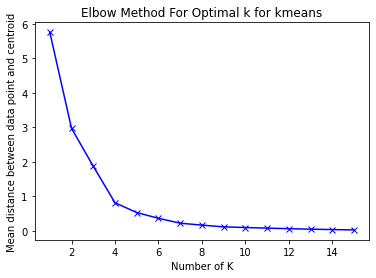

In [50]:
Ks = 16
sse = []

for n in range(1,Ks):
    
    #Train Model and Predict  
    k_means = KMeans(n_clusters = n, random_state=0)
    k_means.fit(X)
    sse.append(k_means.inertia_)

plt.plot(range(1,Ks),sse,'bx-')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
#plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.title('Elbow Method For Optimal k for kmeans')
plt.ylabel('Mean distance between data point and centroid')
plt.xlabel('Number of K')
plt.show()

In [51]:
k_means = KMeans(n_clusters = 4, random_state=0)
k_means.fit(X)
k_means.labels_[0:10]

array([0, 1, 0, 0, 3, 3, 0, 1, 3, 0], dtype=int32)

In [52]:
# add clustering labels
staten_island_rest_pop_data.insert(0, 'Cluster Labels', k_means.labels_)

# prepare rows Chelsea and Travis, Grasmere and Concord for staten_island_data

staten_island_data.drop(staten_island_data[staten_island_data['Neighborhood']=='Concord'].index, inplace=True)
staten_island_data.drop(staten_island_data[staten_island_data['Neighborhood']=='Travis'].index, inplace=True)
staten_island_data['Neighborhood']=staten_island_data['Neighborhood'].replace({'Chelsea' : 'Chelsea-Travis', 
                                                                               'Grasmere' : 'Grasmere - Concord'})

# merge staten_island_rest_pop_data with staten_island_data to add latitude/longitude for each neighborhood
staten_island_data_merged = staten_island_data
staten_island_data_merged = staten_island_data_merged.join(staten_island_rest_pop_data.set_index('Neighborhood'), on='Neighborhood')

staten_island_data_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
0,Staten Island,St. George,40.644982,-74.079353,1.0,9.0,1.0,886.0,12136.0
1,Staten Island,New Brighton,40.640615,-74.087017,3.0,7.0,2.0,247.0,5744.0
2,Staten Island,Stapleton,40.626928,-74.077902,1.0,8.0,1.0,473.0,11536.0
3,Staten Island,Rosebank,40.615305,-74.069805,0.0,7.0,0.0,1653.0,12154.0
4,Staten Island,West Brighton,40.631879,-74.107182,1.0,10.0,1.0,966.0,20553.0
5,Staten Island,Grymes Hill,40.624185,-74.087248,0.0,2.0,0.0,677.0,7606.0
6,Staten Island,Todt Hill,40.597069,-74.111329,0.0,0.0,0.0,693.0,4251.0
7,Staten Island,South Beach,40.580247,-74.079553,0.0,1.0,0.0,635.0,7743.0
8,Staten Island,Port Richmond,40.633669,-74.129434,0.0,1.0,0.0,1469.0,18594.0
9,Staten Island,Mariner's Harbor,40.632546,-74.150085,0.0,2.0,0.0,1156.0,14450.0


In [53]:
#drop NA values, change label name, and column types
staten_island_data_merged.dropna(inplace=True)
staten_island_data_merged.reset_index(drop=True, inplace=True)
staten_island_data_merged.rename(columns={'Cluster Labels' : 'Cluster_Labels'}, inplace=True)
staten_island_data_merged['Cluster_Labels']=staten_island_data_merged.Cluster_Labels.astype('int64')
staten_island_data_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster_Labels,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
0,Staten Island,St. George,40.644982,-74.079353,1,9.0,1.0,886.0,12136.0
1,Staten Island,New Brighton,40.640615,-74.087017,3,7.0,2.0,247.0,5744.0
2,Staten Island,Stapleton,40.626928,-74.077902,1,8.0,1.0,473.0,11536.0
3,Staten Island,Rosebank,40.615305,-74.069805,0,7.0,0.0,1653.0,12154.0
4,Staten Island,West Brighton,40.631879,-74.107182,1,10.0,1.0,966.0,20553.0
5,Staten Island,Grymes Hill,40.624185,-74.087248,0,2.0,0.0,677.0,7606.0
6,Staten Island,Todt Hill,40.597069,-74.111329,0,0.0,0.0,693.0,4251.0
7,Staten Island,South Beach,40.580247,-74.079553,0,1.0,0.0,635.0,7743.0
8,Staten Island,Port Richmond,40.633669,-74.129434,0,1.0,0.0,1469.0,18594.0
9,Staten Island,Mariner's Harbor,40.632546,-74.150085,0,2.0,0.0,1156.0,14450.0


### Visualize the clusters

In [54]:
# create map
n_clusters = 4
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(staten_island_data_merged['Latitude'], staten_island_data_merged['Longitude'], staten_island_data_merged['Neighborhood'], staten_island_data_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters 
Cluster1

In [55]:
staten_island_data_merged.loc[staten_island_data_merged['Cluster_Labels'] == 0, staten_island_data_merged.columns[[1] + list(range(5, staten_island_data_merged.shape[1]))]]

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
3,Rosebank,7.0,0.0,1653.0,12154.0
5,Grymes Hill,2.0,0.0,677.0,7606.0
6,Todt Hill,0.0,0.0,693.0,4251.0
7,South Beach,1.0,0.0,635.0,7743.0
8,Port Richmond,1.0,0.0,1469.0,18594.0
9,Mariner's Harbor,2.0,0.0,1156.0,14450.0
11,New Springville,3.0,0.0,1096.0,5678.0
13,Oakwood,0.0,0.0,420.0,12727.0
15,Eltingville,9.0,0.0,1308.0,23781.0
16,Annadale,2.0,0.0,270.0,7297.0


Cluster2

In [56]:
staten_island_data_merged.loc[staten_island_data_merged['Cluster_Labels'] == 1, staten_island_data_merged.columns[[1] + list(range(5, staten_island_data_merged.shape[1]))]]

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
0,St. George,9.0,1.0,886.0,12136.0
2,Stapleton,8.0,1.0,473.0,11536.0
4,West Brighton,10.0,1.0,966.0,20553.0
12,New Dorp,18.0,1.0,149.0,5137.0
14,Great Kills,11.0,1.0,1011.0,22466.0
21,Park Hill,3.0,1.0,870.0,10235.0
23,Graniteville,6.0,1.0,2035.0,11305.0
27,Dongan Hills,19.0,1.0,593.0,4596.0
28,Midland Beach,2.0,1.0,753.0,9531.0
34,Rossville,2.0,1.0,615.0,10789.0


Cluster3

In [57]:
staten_island_data_merged.loc[staten_island_data_merged['Cluster_Labels'] == 2, staten_island_data_merged.columns[[1] + list(range(5, staten_island_data_merged.shape[1]))]]

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
37,Heartland Village,3.0,0.0,3728.0,20711.0
42,Emerson Hill,0.0,0.0,3092.0,13213.0


Cluster4

In [58]:
staten_island_data_merged.loc[staten_island_data_merged['Cluster_Labels'] == 3, staten_island_data_merged.columns[[1] + list(range(5, staten_island_data_merged.shape[1]))]]

,Neighborhood,Total Restaurants,Total Chinese Restaurants,Asian_Population,Total_Population
1,New Brighton,7.0,2.0,247.0,5744.0
10,Castleton Corners,6.0,2.0,709.0,8862.0
19,Tompkinsville,14.0,2.0,398.0,6317.0
22,Westerleigh,14.0,3.0,266.0,5215.0
39,Bulls Head,13.0,3.0,821.0,13241.0
44,Elm Park,11.0,3.0,151.0,2359.0


## Analysis <a name="analysis"></a>

Cluster 1 (C0) have 0 restaurants and the low to medium low Asian population.
Cluster 2 (C1) have 1 restaurants and the population numbers are similar to C1.
Cluster 3 (C2) have 0 restaurants and the highest Asian population, they indicate a underservered community and thus they have the most potential to host new Chinese restaurants.
Cluster 4 (C3) have 2 or 3 restaurants and low to medium low Asian population which suggest that these neighborhoods are well servered and probably offer low potential for new restaurant.

Next we will focus more on Cluster 1 (C0), Cluster 2 (C1), and Cluster 3 (C2), doing more analysis and pick our top recommendations.

#### Plot the neighborhoods with the most potential for opening new chinese restaurant  

In [59]:
#Prep the staten_island_data_merged data for plot
rest_plot=staten_island_data_merged[['Neighborhood', 'Cluster_Labels', 'Total Chinese Restaurants', 'Asian_Population']]
rest_plot.drop(rest_plot[rest_plot['Cluster_Labels'] == 3].index, inplace=True)
rest_plot.sort_values('Asian_Population', axis=0, ascending=False, inplace=True)
rest_plot.reset_index(drop=True, inplace=True)
rest_plot=rest_plot[['Neighborhood', 'Total Chinese Restaurants', 'Asian_Population']]
rest_plot=rest_plot.head(5)
rest_plot

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Neighborhood,Total Chinese Restaurants,Asian_Population
0,Heartland Village,0.0,3728.0
1,Emerson Hill,0.0,3092.0
2,Graniteville,1.0,2035.0
3,Rosebank,0.0,1653.0
4,Port Richmond,0.0,1469.0


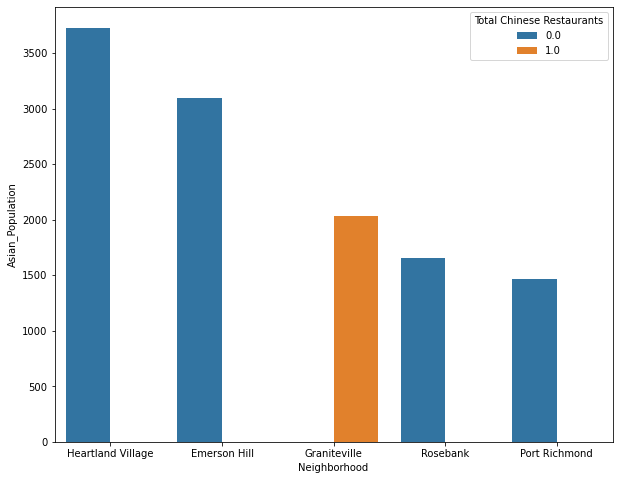

In [60]:
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.barplot(x="Neighborhood", y="Asian_Population", hue="Total Chinese Restaurants", data=rest_plot)
plt.ylabel('Asian_Population')
plt.xticks(rotation=0)
plt.ylim(0,)
plt.xlim()
plt.show()

### Visualize the clusters with all the Chinese restaurants 

In [61]:
 # create map of Staten_Island using latitude and longitude values
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color for Chinese restaurant
# add markers to map
for lat1, lng1, label1 in zip(staten_island_chnrest['Venue Latitude'], staten_island_chnrest['Venue Longitude'], staten_island_chnrest['Venue Category']):
    label1 = folium.Popup(label1, parse_html=True)
    folium.CircleMarker(
        [lat1, lng1],
        radius=5,
        popup=label1,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_restaurants)  

# set color for Neighborhoods as clustered data

# set color scheme for the clusters
n_clusters = 4
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(staten_island_data_merged['Latitude'], staten_island_data_merged['Longitude'], staten_island_data_merged['Neighborhood'], staten_island_data_merged['Cluster_Labels']):
    label2 = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label2,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants)
    
    
map_restaurants

## Results and Discussion <a name="results"></a>

The results show that there is a great number of Chinese restaurants in the northeastern part of the Staten Island (C4 in the clustering analysis). These comunities are relative well served and are excluded from the recommented locations. Sorounding the island there are the neighborhoods with 0 to 1 Chinese restaurant and low to moderate Asian population (C1, C2 in the clustering analysis). their potential are interpreted as average; On the center of the island (C3 in the clustering analysis) the two neighborhoods with the most potential was identified as Heartland Village and Emerson Hill. Both neighborhood has two of the highest Asian population, and none Chinese restaurant to serve the community.

When evaluating the Asian population Bar plot and the map_restaurant Folium map, a third candidate has emerged. Graniteville located in the northwestern part of the island has the third highest Asian population and only one Chinese restaurant serving the area. 

The top recommendation for the most successful place to open a new Chinese restaurant is at Heartland Village. As for the second place, both Emerson Hill and Graniteville have pros and cons, they are in a close call or even could tie for this tier. 



## Conclusion <a name="conclusion"></a>

The top one recommendation is Heartland Village. It has the highest Asian population and no Chinese restaurant serving the area. It is also highly suggested to choose a location close to Staten Island Mall for the best place to set up a new business. Another factor to consider is the fact there are three other kinds of restaurants near the Mall. If a new Chinese restaurant is opened nearby there could be some competition between the four. But since they are not of the same kind of cuisine what they will offer is a more diverse choice of meal to customers. A place with four restaurants near the Mall will be remembered by people as the "Restaurant Corner" and it will attract more and more food passioners to come out and eat here. In short, a new Chinese restaurant in Heartland Village near the Staten Island Mall offers little or no competition from other restaurants, and it will also enjoy a broad customer base from both the Asian folks living in the area and people who visit the Mall. 

For the second place of best success chance, the choice is between Emerson Hill and Graniteville. Emerson Hill has the second most Asian population and none of the Chinese restaurants. However, is a residential neighborhood with few other business and point of attraction. Thus the potential customer base narrowly relies on the residents in the area; Graniteville on the other hand has the third most Asian population, and only one Chinese restaurant. The local shopping plaza being a good place to set up a new Chinese restaurant, this location could provide a similar broad potential customer base just like the Heartland Village case. 

Considering all the pros and cons, overall the second place for the best success chance is given to Graniteville. As for the competition posted by the other restaurant of the same kind, they are the two sides of one coin. Healthy competition can drive business to thrilled, and besides the fact that there is a Chinese restaurant in the area means a pro-Chinese cuisine customer base is already built. A new restaurant of the same kind can start by giving a more diverse choice to Chinese food lovers rather than building customer preference from scratch.  